# Classification de graphes

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapely
import fiona
import dgl
from dgl.data import DGLDataset
import torch
import networkx as nx
import os
import karateclub as kc

## Construction des graphes pour la classification de graphes

### Calcul du voisinage

In [2]:
def preprocess_border(border):
    # plusieurs frontières
    if border.geom_type == "MultiLineString":
        border = shapely.ops.linemerge(border)
    return border


def calc_borders(area, neighbors):
    borders_info = {"total_border": [], "greatest_border": [], "nb_borders": []}
    borders = neighbors.geometry.intersection(area.geometry)
    for border in borders:
        border = preprocess_border(border)
        if border.geom_type == "MultiLineString":
            lengths = gpd.GeoSeries(border.geoms).length
            borders_info["total_border"].append(lengths.sum())
            borders_info["greatest_border"].append(max(lengths))
            borders_info["nb_borders"].append(len(lengths))
        else:
            length = border.length
            borders_info["total_border"].append(length)
            borders_info["greatest_border"].append(length)
            borders_info["nb_borders"].append(1)
    return borders_info


def calc_neighbors(gdf):
    neighbors_dict = {"src": [], "dest": [], "total_border": [], "greatest_border": [], "nb_borders": []}

    for index, area in gdf.iterrows():
        neighbors = gdf[gdf.geometry.touches(area.geometry)]
        neighbors = neighbors[~neighbors['Node_ID'].isin(neighbors_dict['src'])]

        dest = neighbors['Node_ID'].tolist()
        src = [area['Node_ID']] * neighbors.shape[0]

        borders = calc_borders(area, neighbors)

        neighbors_dict["src"].extend(src)
        neighbors_dict["dest"].extend(dest)
        neighbors_dict["total_border"].extend(borders["total_border"])
        neighbors_dict["greatest_border"].extend(borders["greatest_border"])
        neighbors_dict["nb_borders"].extend(borders["nb_borders"])

    return neighbors_dict

### Création des graphes

In [3]:
def generate_graph_data(data_path):
    layers = fiona.listlayers(data_path)
    graph_edges_dict = {"graph_id": [], "src": [], "dest": [], "total_border": [], "greatest_border": [],
                        "nb_borders": []}
    graph_properties_dict = {"graph_id": [], "num_nodes": []}

    for i in range(len(layers)):
        print(layers[i], end=" ")
        gdf = gpd.read_file(data_path, layer=layers[i])
        neighbors = calc_neighbors(gdf)

        graph_properties_dict["graph_id"].append(layers[i])
        graph_properties_dict["num_nodes"].append(len(gdf))

        graph_edges_dict["src"].extend(neighbors["src"])
        graph_edges_dict["dest"].extend(neighbors["dest"])
        graph_edges_dict["total_border"].extend(neighbors["total_border"])
        graph_edges_dict["greatest_border"].extend(neighbors["greatest_border"])
        graph_edges_dict["nb_borders"].extend(neighbors["nb_borders"])
        graph_edges_dict["graph_id"].extend([layers[i]] * len(neighbors["src"]))

        print("[ok]", end=" | ")

    graph_edges_df = pd.DataFrame(graph_edges_dict)
    graph_properties_df = pd.DataFrame(graph_properties_dict)

    return graph_edges_df, graph_properties_df

In [9]:
# capitales
# graph_edges_df, graph_properties_df = generate_graph_data("../data/capitales/data.gpkg")
# # graph_properties_df["label"] = int(graph_properties_df["label"] in capitals)
# graph_edges_df.to_csv("../data/capitales/graph_edges.csv")
# graph_properties_df.to_csv("../data/capitales-campagnes/graph_properties.csv")

In [ ]:
# communes
graph_edges_df, graph_properties_df = generate_graph_data("../data/communes/communes_clc.gpkg")
graph_properties_df["label"] = graph_properties_df["graph_id"].map(lambda graph_id: graph_id[:2] == 'FR')
graph_edges_df.to_csv("../data/communes/graphs/graph_edges.csv")
graph_properties_df.to_csv("../data/communes/graphs/graph_properties.csv")

In [4]:
from dgl.data.utils import save_info, load_info


class DGLClassDataset(DGLDataset):
    def __init__(self, name, save_dir, edges_path, properties_path, data_path):
        self.data_path = data_path
        self.edges = pd.read_csv(edges_path)
        self.properties = pd.read_csv(properties_path)
        self.graphs = []
        self.labels = []
        self.ids = []
        super().__init__(name=name, save_dir=save_dir)

    def process(self):
        # Create a graph for each graph ID from the edges table.
        # First process the properties table into two dictionaries with graph IDs as keys.
        # The label and number of nodes are values.
        label_dict = {}
        num_nodes_dict = {}
        for _, row in self.properties.iterrows():
            label_dict[row['graph_id']] = row['label']
            num_nodes_dict[row['graph_id']] = row['num_nodes']

        # For the edges, first group the table by graph IDs.
        edges_group = self.edges.groupby('graph_id')

        # For each graph ID...
        for graph_id in edges_group.groups:
            # Find the edges as well as the number of nodes and its label.
            edges_of_id = edges_group.get_group(graph_id)
            num_nodes = num_nodes_dict[graph_id]
            label = label_dict[graph_id]

            # Create a graph and add it to the list of graphs and labels.
            src = edges_of_id['src'].to_numpy()
            dest = edges_of_id['dest'].to_numpy()
            g = dgl.graph((src, dest), num_nodes=num_nodes)

            data = gpd.read_file(self.data_path, layer=graph_id)

            g.ndata['area'] = torch.from_numpy(data.area.to_numpy())
            g.ndata['label'] = torch.from_numpy(data['Node_Label'].to_numpy())
            g.edata['total_border'] = torch.from_numpy(edges_of_id['total_border'].to_numpy())
            g.edata['greatest_border'] = torch.from_numpy(edges_of_id['greatest_border'].to_numpy())
            g.edata['nb_borders'] = torch.from_numpy(edges_of_id['nb_borders'].to_numpy())

            self.graphs.append(g)
            self.labels.append(label)
            self.ids.append(graph_id)

        # Convert the label list to tensor for saving.
        self.labels = torch.LongTensor(self.labels)

    def save(self):
        # save graphs and labels
        graph_path = os.path.join(self.save_path, 'dgl_graph.bin')
        dgl.save_graphs(graph_path, self.graphs, {'labels': self.labels})
        # save other information in python dict
        info_path = os.path.join(self.save_path, 'info.pkl')
        save_info(info_path, {'ids': self.ids})

    def load(self):
        # load processed data from directory `self.save_path`
        graph_path = os.path.join(self.save_path, 'dgl_graph.bin')
        self.graphs, label_dict = dgl.load_graphs(graph_path)
        self.labels = label_dict['labels']
        info_path = os.path.join(self.save_path, 'info.pkl')
        self.ids = load_info(info_path)['ids']

    def has_cache(self):
        # check whether there are processed data in `self.save_path`
        graph_path = os.path.join(self.save_path, 'dgl_graph.bin')
        info_path = os.path.join(self.save_path, 'info.pkl')
        return os.path.exists(graph_path) and os.path.exists(info_path)

    def __getitem__(self, i):
        return self.graphs[i], self.labels[i], self.ids[i]

    def get_graphs(self):
        return self.graphs

    def get_labels(self):
        return self.labels

    def get_ids(self):
        return self.ids

    def __len__(self):
        return len(self.graphs)

In [5]:
communes_dgl_dataset = DGLClassDataset(name="communes", save_dir="../data/communes/graphs",
                                       edges_path="../data/communes/graphs/graph_edges.csv",
                                       properties_path="../data/communes/graphs/graph_properties.csv",
                                       data_path="../data/communes/communes_clc.gpkg")

### Visualisation des graphes

In [6]:
def draw_map_graph(nx_graph, gdf, column=None, legend=False, ax=None):
    pos = {}
    points = gdf.representative_point()
    for i in range(len(gdf)):
        area = gdf.iloc[i]
        point = points.iloc[i]
        pos[area['Node_ID']] = (point.x, point.y)

    gdf.plot(column, legend=legend, ax=ax)
    nx.draw(nx_graph, pos=pos, with_labels=True, ax=ax, node_color=[(0, 0, 0, 0.7)], font_color="white")

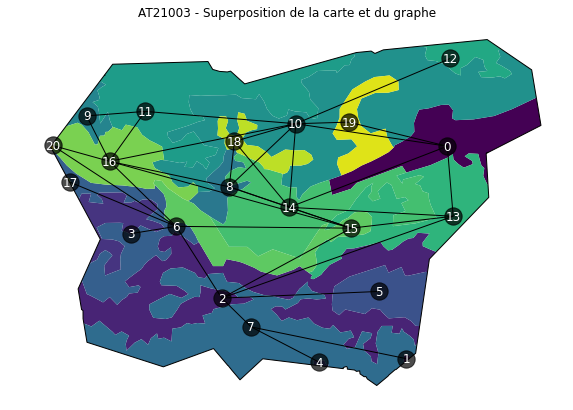

In [7]:
graph, label, id = communes_dgl_dataset[6]
g_nx = dgl.to_networkx(graph, node_attrs=graph.ndata.keys(), edge_attrs=graph.edata.keys()).to_undirected()
f, ax = plt.subplots(figsize=(14, 7))
gdf = gpd.read_file("../data/communes/communes_clc.gpkg", layer=id)
gdf.dissolve().exterior.plot(ax=ax, color="black", linewidth=1)
draw_map_graph(g_nx, gdf=gdf, column=np.array(range(len(gdf))), ax=ax)
plt.title(f"{id} - Superposition de la carte et du graphe")
plt.show()

In [ ]:
### exportations

## graphviz
# path = './a.out.png'
#
# ag = nx.nx_agraph.to_agraph(g_nx)
# ag.layout()
# ag.draw(path)
#
# img = mpimg.imread(path)
# plt.figure(figsize=(10,5))
# plt.imshow(img)
# plt.title(label)
# plt.show()
#
# os.remove(path)

## graphml
# nx.write_graphml(g_nx, "test.graphml") # peut être utilisé avec cytoscape

## dot
# nx.drawing.nx_agraph.write_dot(g_nx, "test.dot") # dot file

## Classification des graphes

### Graph embedding

In [9]:
# karate club: https://karateclub.readthedocs.io/en/latest/index.html

In [8]:
graphs = [nx.Graph(dgl.to_networkx(graph, node_attrs=graph.ndata.keys(), edge_attrs=graph.edata.keys()).to_undirected())
          for graph
          in communes_dgl_dataset.get_graphs()]

### graph2vec

In [9]:
# création de l'attribut 'feature' pour appliquer graph2vec
for graph in graphs:
    for node in graph.nodes:
        graph.nodes[node]["feature"] = str(graph.nodes[node]["label"].item())

In [10]:
graph2vec = kc.Graph2Vec()
graph2vec.fit(graphs)

In [24]:
g2v_dataset = graph2vec.get_embedding()
g2v_dataset[0]

array([ 0.05742242, -0.02707503, -0.10531396,  0.14921108, -0.01408883,
       -0.07792623,  0.01180727, -0.08254835,  0.04502292, -0.08671109,
       -0.17272381,  0.17864956, -0.15373792, -0.02865432, -0.04918971,
        0.0873341 ,  0.01947728, -0.03657529, -0.06615262,  0.01443118,
        0.10565023,  0.02148533,  0.06445283, -0.01468558, -0.092452  ,
        0.10283694,  0.10638025, -0.15025392, -0.07418056, -0.01112494,
       -0.0102048 , -0.05159266, -0.0047892 ,  0.05877893, -0.00579982,
       -0.0468135 ,  0.08686139, -0.052333  ,  0.01846437,  0.04174189,
       -0.096467  ,  0.02017893, -0.0330307 ,  0.01741504, -0.12154522,
        0.04858633, -0.04077415,  0.0802828 ,  0.0207111 , -0.03051394,
        0.04024509, -0.03710075,  0.0982761 , -0.02896527,  0.06025293,
        0.06936046,  0.03360514, -0.05414754, -0.08550137,  0.07623734,
       -0.01689026,  0.03434577,  0.12564531,  0.13623054,  0.09780245,
        0.08770935, -0.05979802, -0.04279927,  0.17590798,  0.03

## Classification

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(g2v_dataset, communes_dgl_dataset.get_labels().numpy(),
                                                    test_size=0.2,
                                                    random_state=42)

In [13]:
from tensorflow import keras

def make_model(input_shape):
    return keras.models.Sequential([
        keras.layers.Input(input_shape),
        # keras.layers.Dense(64, activation='relu'),
        # keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.Dropout(rate=0.1), # drop 10% of the units of the previous layer
        keras.layers.Dense(2, activation='softmax')
    ])

In [14]:
model = make_model(X_train[0].shape)

2022-03-22 13:19:05.479946: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                2064      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 2,098
Trainable params: 2,098
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer=keras.optimizers.SGD(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, batch_size=len(X_train), epochs=100, validation_split=0.2, callbacks=[early_stopping_cb])

In [18]:
model.evaluate(X_test, y_test)

10/10 [==============================] - 0s 1ms/step - loss: 0.9589 - accuracy: 0.5186


[0.9588911533355713, 0.5186440944671631]

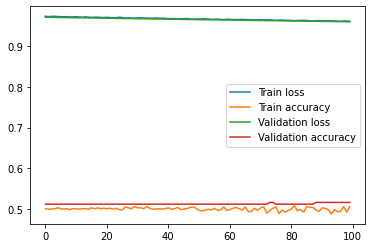

In [19]:
training_loss = history.history['loss']
training_acc  = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc  = history.history['val_accuracy']

import matplotlib.pyplot as plt

plt.plot(training_loss, label="Train loss")
plt.plot(training_acc,  label="Train accuracy")
plt.plot(val_loss, label="Validation loss")
plt.plot(val_acc,  label="Validation accuracy")
plt.legend()
plt.show()